In [ ]:
!pip install torchsummary


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, tensor
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

dataset_df = pd.read_csv('riceClassification.csv')
dataset_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [ ]:
dataset_df.dropna(inplace=True)
dataset_df.drop(["id"], axis=1, inplace=True)
print(dataset_df.shape)
print(dataset_df["Class"].value_counts())

(18185, 11)
Class
1    9985
0    8200
Name: count, dtype: int64


In [ ]:
num_pos = dataset_df[dataset_df["Class"] == 1].shape[0]
num_neg = dataset_df[dataset_df["Class"] == 0].shape[0]

pos_weight = num_neg / num_pos
print(pos_weight)

pos_weight_tensor = tensor([pos_weight], requires_grad=True)
print(pos_weight_tensor)

los_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

0.8212318477716575
tensor([0.8212], requires_grad=True)


In [ ]:
original_df = dataset_df.copy()
original_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [ ]:
for column in dataset_df.columns:
  dataset_df[column] = dataset_df[column] / dataset_df[column].abs().max()

In [ ]:
X = dataset_df.drop(["Class"], axis=1)
y = dataset_df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)


(12729, 10) (2728, 10) (2728, 10)
(12729,) (2728,) (2728,)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

class dataset(Dataset):
  def __init__(self, X, y):
    self.X = tensor(X.values, dtype=torch.float32).to(device)
    self.y = tensor(y.values, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)
  def __getitem__(self, index):
    return self.X[index], self.y[index]

cuda


In [ ]:
training_data = dataset(X_train, y_train)
testing_data = dataset(X_test, y_test)
validation_data = dataset(X_val, y_val)

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=8, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=8, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=8, shuffle=True)

In [ ]:
hidden_neurons = 10

class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()

    self.input_layer = nn.Linear(X.shape[1], hidden_neurons)
    self.relu = nn.ReLU()
    self.output_layer = nn.Linear(hidden_neurons, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.input_layer(x)
    x = self.relu(x)
    x = self.output_layer(x)
    x = self.sigmoid(x)
    return x

model = MyModel().to(device)

In [ ]:
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
              ReLU-2                   [-1, 10]               0
            Linear-3                    [-1, 1]              11
           Sigmoid-4                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.005)

In [ ]:
total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

epochs = 10
for epoch in range(epochs):
  total_loss_train = 0
  total_loss_val = 0
  total_acc_train = 0
  total_acc_val = 0

  for data in train_dataloader:
    inputs, label = data
    prediction = model(inputs).squeeze(1)
    batch_loss = criterion(prediction, label)
    total_loss_train += batch_loss.item()
    acc = ((prediction).round() == label).sum().item()
    total_acc_train += acc

    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  with torch.no_grad():
    for data in val_dataloader:
      inputs, label = data
      prediction = model(inputs).squeeze(1)
      batch_loss = criterion(prediction, label)
      total_loss_val += batch_loss.item()
      acc = ((prediction).round() == label).sum().item()
      total_acc_val += acc
  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_val_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/training_data.__len__() * 100, 4))
  total_acc_val_plot.append(round(total_acc_val/validation_data.__len__() * 100, 4))

  print(f'''Epoch: {epoch+1} Train loss: {round(total_loss_train/1000, 4)} Train Accuracy: {round(total_acc_train/training_data.__len__() * 100, 4)}
        Validation loss: {round(total_loss_val/1000, 4)}, Validation accuracy: {round(total_acc_val/validation_data.__len__() * 100, 4)}''')

Epoch: 1 Train loss: 0.2531 Train Accuracy: 96.8261
        Validation loss: 0.0205, Validation accuracy: 98.1672
Epoch: 2 Train loss: 0.0788 Train Accuracy: 98.4052
        Validation loss: 0.0161, Validation accuracy: 98.4238
Epoch: 3 Train loss: 0.0762 Train Accuracy: 98.4288
        Validation loss: 0.0153, Validation accuracy: 98.4604
Epoch: 4 Train loss: 0.0744 Train Accuracy: 98.4838
        Validation loss: 0.0152, Validation accuracy: 98.6437
Epoch: 5 Train loss: 0.0736 Train Accuracy: 98.5466
        Validation loss: 0.0153, Validation accuracy: 98.5704
Epoch: 6 Train loss: 0.0731 Train Accuracy: 98.4995
        Validation loss: 0.0159, Validation accuracy: 98.5704
Epoch: 7 Train loss: 0.0759 Train Accuracy: 98.3188
        Validation loss: 0.0185, Validation accuracy: 98.2038
Epoch: 8 Train loss: 0.0731 Train Accuracy: 98.3738
        Validation loss: 0.0375, Validation accuracy: 96.0044
Epoch: 9 Train loss: 0.0739 Train Accuracy: 98.3345
        Validation loss: 0.0183, Val

In [ ]:
with torch.no_grad():
  correct = 0
  total = 0
  for data in test_dataloader:
    inputs, label = data
    prediction = model(inputs).squeeze(1)
    acc = ((prediction).round() == label).sum().item()
    correct += acc
    total += label.shape[0]
  print(f'Test accuracy: {round(correct/total * 100, 4)}')

Test accuracy: 98.7903


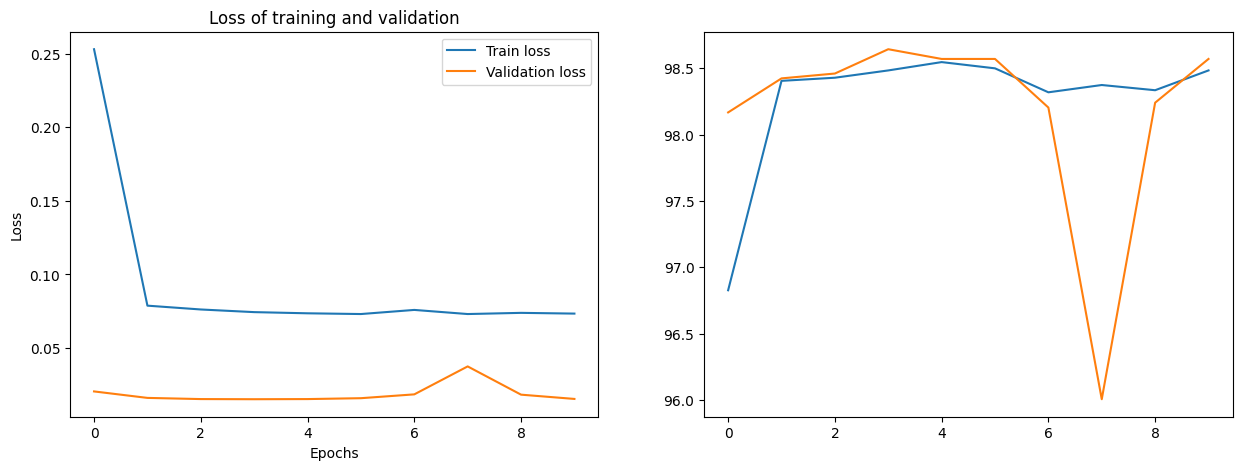

In [ ]:
fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
axis[0].plot(total_loss_train_plot, label = 'Train loss')
axis[0].plot(total_loss_val_plot, label = 'Validation loss')
axis[0].set_title("Loss of training and validation")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Loss")
axis[0].legend()

axis[1].plot(total_acc_train_plot, label = 'Train accuracy')
axis[1].plot(total_acc_val_plot, label = 'Validation accuracy')

In [ ]:
original_df

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1
...,...,...,...,...,...,...,...,...,...,...,...
18180,5853,148.624571,51.029281,0.939210,6008,86.326537,0.498594,332.960,0.663444,2.912535,0
18181,7585,169.593996,58.141659,0.939398,7806,98.272692,0.647461,385.506,0.641362,2.916910,0
18182,6365,154.777085,52.908085,0.939760,6531,90.023162,0.561287,342.253,0.682832,2.925396,0
18183,5960,151.397924,51.474600,0.940427,6189,87.112041,0.492399,343.371,0.635227,2.941216,0


In [ ]:
area = 2353/original_df["Area"].abs().max()
majoraxislength = 81/original_df["MajorAxisLength"].abs().max()
minoraxislength = 81/original_df["MinorAxisLength"].abs().max()